In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from scipy.signal import find_peaks

import matplotlib.colors as mcolors

current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 
import cigar as cig

from tqdm import tqdm


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
colors = ['royalblue', 'crimson', 'black', 'green', 'darkorange', 'brown', 'coral', 'indigo', 'magenta', 'blue']


##  Data reading

In [3]:

start           = 1
nfiles          = 11


In [4]:
amp_factors = {'CH1':269,
               'CH2':267,
               'CH3':258,
               'CH4':275
               }

amplified = False

temperature = 9 # [deg]

pes = True

nchannels       = 10


In [5]:
data_nosource = {'source':'no-source',
                 'run':'Run19',
                 'nchannels': nchannels,
                 'nevents_per_wvf': 500,
                 'samples_per_waveform': 752,
                 'event_header_bytes': 28,
                 'sample_binning': 8e-9,
                 'integration_window_min':1.8e-6,
                 'integration_window_max':3e-6,
                 'temperature':f'{temperature}deg',
                 'is_amplified':amplified,
                 'amp_factors':amp_factors,
                 'pes':pes
                 }

run_nosource_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{data_nosource['run']}"


In [6]:
data_source = {'source':'Ba133',
               'run':'Run22',
               'nchannels': nchannels,
               'nevents_per_wvf': 500,
               'samples_per_waveform': 752,
               'event_header_bytes': 28,
               'sample_binning': 8e-9,
               'integration_window_min':1.8e-6,
               'integration_window_max':3e-6,
               'temperature':f'{temperature}deg',
               'is_amplified':amplified,
               'amp_factors':amp_factors,
               'pes':pes
               }

run_source_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{data_source['run']}"


In [7]:
parse_data.checkWfs(run_nosource_dir, 
                    1, 5, 
                    data_nosource['nchannels'], 
                    data_nosource['samples_per_waveform'], 
                    data_nosource['event_header_bytes'], 
                    print_headers = False
                    )

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run19
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)


In [8]:
parse_data.checkWfs(run_source_dir, 
                    1, 5, 
                    data_source['nchannels'], 
                    data_source['samples_per_waveform'], 
                    data_source['event_header_bytes'], 
                    print_headers = False
                    )

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run22
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)


In [9]:

# Initialize an empty list to store DataFrames
dataframes_nosource = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_nosource_dir)[start:nfiles],desc=f"Reading {data_nosource['source']} .bin files", unit="file")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_nosource_dir, file)
        df = parse_data.parse_wf_from_binary(file_path, 
                                             channels = data_nosource['nchannels'], 
                                             n_events = data_nosource['nevents_per_wvf'],
                                             file_idx = i,
                                             event_header_bytes = data_nosource['event_header_bytes'],
                                             sample_binning = data_nosource['sample_binning']
                                             )   
        dataframes_nosource.append(df)

Reading no-source .bin files: 100%|██████████| 10/10 [00:20<00:00,  2.05s/file]


In [10]:

# Initialize an empty list to store DataFrames
dataframes_source = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_source_dir)[-nfiles:-start],desc=f"Reading {data_source['source']} .bin files", unit="files")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_source_dir, file)
        df = parse_data.parse_wf_from_binary(file_path, 
                                            channels = data_source['nchannels'], 
                                            n_events = data_source['nevents_per_wvf'],
                                            file_idx = i,
                                            event_header_bytes = data_source['event_header_bytes'],
                                            sample_binning = data_source['sample_binning']
                                            )  
        dataframes_source.append(df)

Reading Ba133 .bin files: 100%|██████████| 10/10 [00:18<00:00,  1.83s/files]


In [11]:
# Merge all DataFrames into one
merged_df_source    = pd.concat(dataframes_source, ignore_index=True)
merged_df_nosource  = pd.concat(dataframes_nosource, ignore_index=True)

In [12]:
merged_df_source.tail()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,event,event_time,file_idx
3759995,0.000006,3.000907,2.636158,-368.640015,-533.874512,-409.954376,-531.537781,-351.508514,-558.209839,-407.899323,-533.113037,4999,379323641269,9
3759996,0.000006,2.755935,2.942688,-368.394226,-539.889709,-409.831482,-545.277039,-350.710907,-560.479248,-408.206909,-539.187866,4999,379323641269,9
3759997,0.000006,2.694692,2.881382,-367.718414,-550.630981,-409.462830,-563.432495,-349.974609,-559.375183,-408.637512,-547.717224,4999,379323641269,9
3759998,0.000006,2.572206,3.187912,-368.332794,-565.362000,-409.524261,-584.654724,-349.790558,-556.431091,-408.760529,-557.228333,4999,379323641269,9
3759999,0.000006,2.572206,3.126606,-368.640015,-582.548096,-409.708588,-605.386292,-349.422424,-555.879089,-408.883545,-568.028015,4999,379323641269,9


In [13]:
merged_df_nosource.tail()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,event,event_time,file_idx
3759995,0.000006,2.265991,2.881382,-369.623047,-533.076599,-409.954376,-589.500305,-349.851898,-515.950012,-407.960846,-495.620880,4999,134237498655,9
3759996,0.000006,2.327234,2.881382,-370.237427,-506.745026,-410.384491,-593.487122,-349.606476,-518.648743,-408.883545,-505.684235,4999,134237498655,9
3759997,0.000006,2.510963,2.574852,-369.745911,-463.227325,-410.200134,-595.327209,-349.606476,-520.488831,-409.129608,-516.668030,4999,134237498655,9
3759998,0.000006,2.327234,2.574852,-369.868805,-408.047577,-410.507355,-597.535339,-350.035980,-520.550171,-409.314148,-525.381470,4999,134237498655,9
3759999,0.000006,2.082262,2.636158,-369.192963,-351.640289,-410.445923,-601.460815,-350.649536,-522.696899,-408.637512,-526.854126,4999,134237498655,9


##  Data selection

In [14]:
# Filter for a specific event (change index as needed)
event_list_source  = merged_df_source['event'].unique()
nevents_source     = len(event_list_source)
print(f'Events per file = {len(event_list_source)/len(os.listdir(run_source_dir)[-nfiles:-start])}. Total nevents = {len(event_list_source)}')

Events per file = 500.0. Total nevents = 5000


In [15]:
# Filter for a specific event (change index as needed)
event_list_nosource  = merged_df_nosource['event'].unique()
nevents_nosource     = len(event_list_nosource)
print(f'Events per file = {len(event_list_nosource)/len(os.listdir(run_nosource_dir)[start:nfiles])}. Total nevents = {len(event_list_nosource)}')


Events per file = 500.0. Total nevents = 5000


In [16]:
if nchannels == 5:
    Amp_channels    = ['CH2', 'CH3', 'CH4', 'CH5'] # Amp
    noAmp_channels  = [] # noAmp

elif nchannels == 9:
    Amp_channels    = ['CH3', 'CH5', 'CH7', 'CH9'] # Amp
    noAmp_channels  = ['CH2', 'CH4', 'CH6', 'CH8'] # noAmp

elif nchannels == 10:
    Amp_channels    = ['CH4', 'CH6', 'CH8', 'CH10'] # Amp
    noAmp_channels  = ['CH3', 'CH5', 'CH7', 'CH9'] # noAmp

if amplified:
    channels = Amp_channels
else:
    channels = noAmp_channels

all_channels    = noAmp_channels + Amp_channels


##  Data filtering

In [17]:
# function to count number of peaks above threshold for one waveform
def count_high_peaks(group, channels_to_check, threshold=1000):
    peak_count = 0
    for ch in channels_to_check:
        peaks, _ = find_peaks(group[f'{ch}'].values, height=threshold)
        peak_count += len(peaks)
    return peak_count

# group by event (or event_time if that's more appropriate)
peak_counts_source      = merged_df_source.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels)
peak_counts_nosource    = merged_df_nosource.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels)

# keep only events with <= 5 peaks above 2000
valid_events_source     = peak_counts_source[peak_counts_source <= 5].index
valid_events_nosource   = peak_counts_nosource[peak_counts_nosource <= 5].index

# filter the original dataframe
filtered_df_source = merged_df_source[merged_df_source["event"].isin(valid_events_source)]
filtered_df_nosource = merged_df_nosource[merged_df_nosource["event"].isin(valid_events_nosource)]

# update the number of valid events
event_list_source  = filtered_df_source['event'].unique()
nevents_source     = len(event_list_source)

event_list_nosource  = filtered_df_nosource['event'].unique()
nevents_nosource     = len(event_list_nosource)

/tmp/ipykernel_92098/476222686.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_counts_source      = merged_df_source.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels)
/tmp/ipykernel_92098/476222686.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_counts_nosource    = merged_df_nosource.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels)


##  Baseline correction

In [18]:
# DEFINITION OF THE BASELINE WINDOW WIDTH HERE
window_width = 10


In [19]:
corrected_df_nosource   = filtered_df_nosource.copy()
corrected_df_source     = filtered_df_source.copy()
for i, ch in enumerate(all_channels):

    # NO SOURCE -------------------------------------------------------------------------
    voltage_nosource = filtered_df_nosource[f'{all_channels[i]}'].values

    v_matrix_nosource                    = voltage_nosource.reshape(nevents_nosource, -1)
    v_matrix_corrected_nosource, _, _    = cig.BaselineCorrection(v_matrix_nosource, window=window_width)

    corrected_df_nosource[f'{all_channels[i]}'] = v_matrix_corrected_nosource.flatten()
    # SOURCE -------------------------------------------------------------------------
    voltage_source = filtered_df_source[f'{all_channels[i]}'].values

    v_matrix_source                    = voltage_source.reshape(nevents_source, -1)
    v_matrix_corrected_source, _, _    = cig.BaselineCorrection(v_matrix_source, window=window_width)

    corrected_df_source[f'{all_channels[i]}'] = v_matrix_corrected_source.flatten()


/home/marian/CIGAR_ANALYSIS/CIGAR/functions/cigar.py:980: RuntimeWarning: invalid value encountered in sqrt
  rms = np.sqrt(sq_mean)                                # (nevents, nsamples)


In [20]:
corrected_df_nosource

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,event,event_time,file_idx
752,8.000000e-09,2.572206,3.003994,1.800177,123.334979,1.370203,119.132886,1.809991,85.034845,1.937704,460.460449,1,362531206068,0
753,1.600000e-08,2.388477,3.249218,1.923071,127.386005,1.062982,119.194226,1.809991,72.215814,2.122244,444.751785,1,362531206068,0
754,2.400000e-08,2.388477,2.390934,2.230261,150.096210,1.124414,120.604993,2.300867,56.882074,1.937704,420.022888,1,362531206068,0
755,3.200000e-08,2.143505,2.452240,1.677313,196.866992,1.247308,127.903943,2.116785,46.393793,1.999197,396.214447,1,362531206068,0
756,4.000000e-08,2.939664,2.758770,2.107397,255.361194,1.493097,137.840405,2.669000,43.572382,2.245261,380.383057,1,362531206068,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3759243,5.984000e-06,2.265991,2.452240,0.288770,30.155493,0.018442,98.591504,1.343683,36.586346,2.509784,377.278125,4998,133999612352,9
3759244,5.992000e-06,2.082262,2.513546,0.227338,37.582373,0.632883,127.910107,1.895898,30.698163,2.694324,359.789966,4998,133999612352,9
3759245,6.000000e-06,2.265991,2.881382,-0.387073,42.922339,1.554544,181.395093,2.264032,24.687360,2.079181,341.319995,4998,133999612352,9
3759246,6.008000e-06,2.694692,3.065300,0.043011,47.587134,1.738870,249.968732,2.202692,20.516583,1.956134,323.525012,4998,133999612352,9


##  Sum calculation

In [21]:
corrected_df_source      = cig.CreateWfSum(corrected_df_source, channels, data_source)
corrected_df_nosource    = cig.CreateWfSum(corrected_df_nosource, channels, data_nosource)
channels.append('CHSum')

['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9', 'CH10']
['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9', 'CH10']


In [22]:
corrected_df_source

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,CHSum,event,event_time,file_idx
0,8.000000e-09,2.817178,3.126606,0.792575,149.003650,1.333347,208.247986,3.405243,360.312457,1.863861,97.725085,7.395026,0,234372553136,0
1,1.600000e-08,2.817178,2.942688,0.546817,148.144336,1.087558,196.471497,3.159821,342.279987,1.002686,91.466174,5.796881,0,234372553136,0
2,2.400000e-08,3.062150,2.636158,0.792575,144.093341,1.394778,184.572266,2.853058,325.596851,1.187225,90.852588,6.227637,0,234372553136,0
3,3.200000e-08,2.449720,2.207016,0.362491,140.349231,2.255008,174.635864,2.484924,312.225818,1.556305,96.313770,6.658728,0,234372553136,0
4,4.000000e-08,2.327234,2.145710,0.116733,136.973376,2.132114,165.864807,1.932709,299.222797,1.617828,102.388599,5.799384,0,234372553136,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3759243,5.984000e-06,2.572206,3.065300,2.193396,184.879681,0.958517,142.961957,3.527957,528.775174,1.341003,81.550079,8.020874,4998,379319746656,9
3759244,5.992000e-06,2.755935,2.758770,2.439185,166.772870,0.712759,144.249982,3.343906,507.062589,1.710083,79.586517,8.205933,4998,379319746656,9
3759245,6.000000e-06,2.449720,2.390934,2.439185,152.962567,0.159750,147.930157,3.037112,492.158185,1.525543,75.720734,7.161591,4998,379319746656,9
3759246,6.008000e-06,2.817178,2.820076,2.684943,143.019208,0.897086,150.015607,3.343906,479.339154,1.648560,70.014069,8.574493,4998,379319746656,9


In [23]:
os.listdir(run_source_dir)

['Acq_dig2-192.168.0.254_20251029173856-40.bin',
 'Acq_dig2-192.168.0.254_20251029170233-40.bin',
 'Acq_dig2-192.168.0.254_20251029174650-40.bin',
 'Acq_dig2-192.168.0.254_20251029171841-40.bin',
 'Acq_dig2-192.168.0.254_20251029172919-40.bin',
 'Acq_dig2-192.168.0.254_20251029175955-40.bin',
 'Acq_dig2-192.168.0.254_20251029170607-40.bin',
 'Acq_dig2-192.168.0.254_20251029173714-40.bin',
 'Acq_dig2-192.168.0.254_20251029175443-40.bin',
 'Acq_dig2-192.168.0.254_20251029174137-40.bin',
 'Acq_dig2-192.168.0.254_20251029174414-40.bin',
 'Acq_dig2-192.168.0.254_20251029172728-40.bin',
 'Acq_dig2-192.168.0.254_20251029180455-40.bin',
 'Acq_dig2-192.168.0.254_20251029175900-40.bin',
 'Acq_dig2-192.168.0.254_20251029173253-40.bin',
 'Acq_dig2-192.168.0.254_20251029174225-40.bin',
 'Acq_dig2-192.168.0.254_20251029175302-40.bin',
 'Acq_dig2-192.168.0.254_20251029170044-40.bin',
 'Acq_dig2-192.168.0.254_20251029173950-40.bin',
 'Acq_dig2-192.168.0.254_20251029170706-40.bin',
 'Acq_dig2-192.168.0

In [24]:
((corrected_df_source.groupby('file_idx').max().event_time - corrected_df_source.groupby('file_idx').min().event_time)*8e-9).sum()

534.4062091440001

In [25]:
(corrected_df_source.event_time.max() - corrected_df_source.event_time.min())

392682910541

In [26]:
date = pd.to_datetime(corrected_df_source.event_time*8e-9, unit='s', utc = True).dt.tz_convert('Europe/Madrid')

In [27]:
date

0         1970-01-01 01:31:14.980425088+01:00
1         1970-01-01 01:31:14.980425088+01:00
2         1970-01-01 01:31:14.980425088+01:00
3         1970-01-01 01:31:14.980425088+01:00
4         1970-01-01 01:31:14.980425088+01:00
                          ...                
3759243   1970-01-01 01:50:34.557973248+01:00
3759244   1970-01-01 01:50:34.557973248+01:00
3759245   1970-01-01 01:50:34.557973248+01:00
3759246   1970-01-01 01:50:34.557973248+01:00
3759247   1970-01-01 01:50:34.557973248+01:00
Name: event_time, Length: 2589136, dtype: datetime64[ns, Europe/Madrid]

In [28]:
(corrected_df_nosource.event_time.max() - corrected_df_nosource.event_time.min())*1e-9/3600

0.3832309543522222

In [29]:
corrected_df_nosource['CH3'].mean()

1.8851128042945122

In [30]:
np.mean(list(data_source['amp_factors'].values())) 

267.25

##  Charge spectrum

In [31]:
nevents_source, nevents_nosource

(3443, 3468)

In [32]:
corrected_df_nosource.groupby('event').size().unique()

array([752])

In [33]:
t_matrix_source = corrected_df_source['TIME'].values.reshape(nevents_source, -1)
time_source     = t_matrix_source[0]

t_matrix_nosource = corrected_df_nosource['TIME'].values.reshape(nevents_nosource, -1)
time_nosource     = t_matrix_nosource[0]

In [34]:
time_window_source      = (1.8e-6 < time_source)  & (time_source < 3.5e-6)
time_window_nosource    = (1.8e-6 < time_nosource)  & (time_nosource < 3.5e-6)

# time_window_source      = (0.5e-6 < time_source)  & (time_source < 3e-6)
# time_window_nosource    = (0.5e-6 < time_nosource)  & (time_nosource < 3e-6)

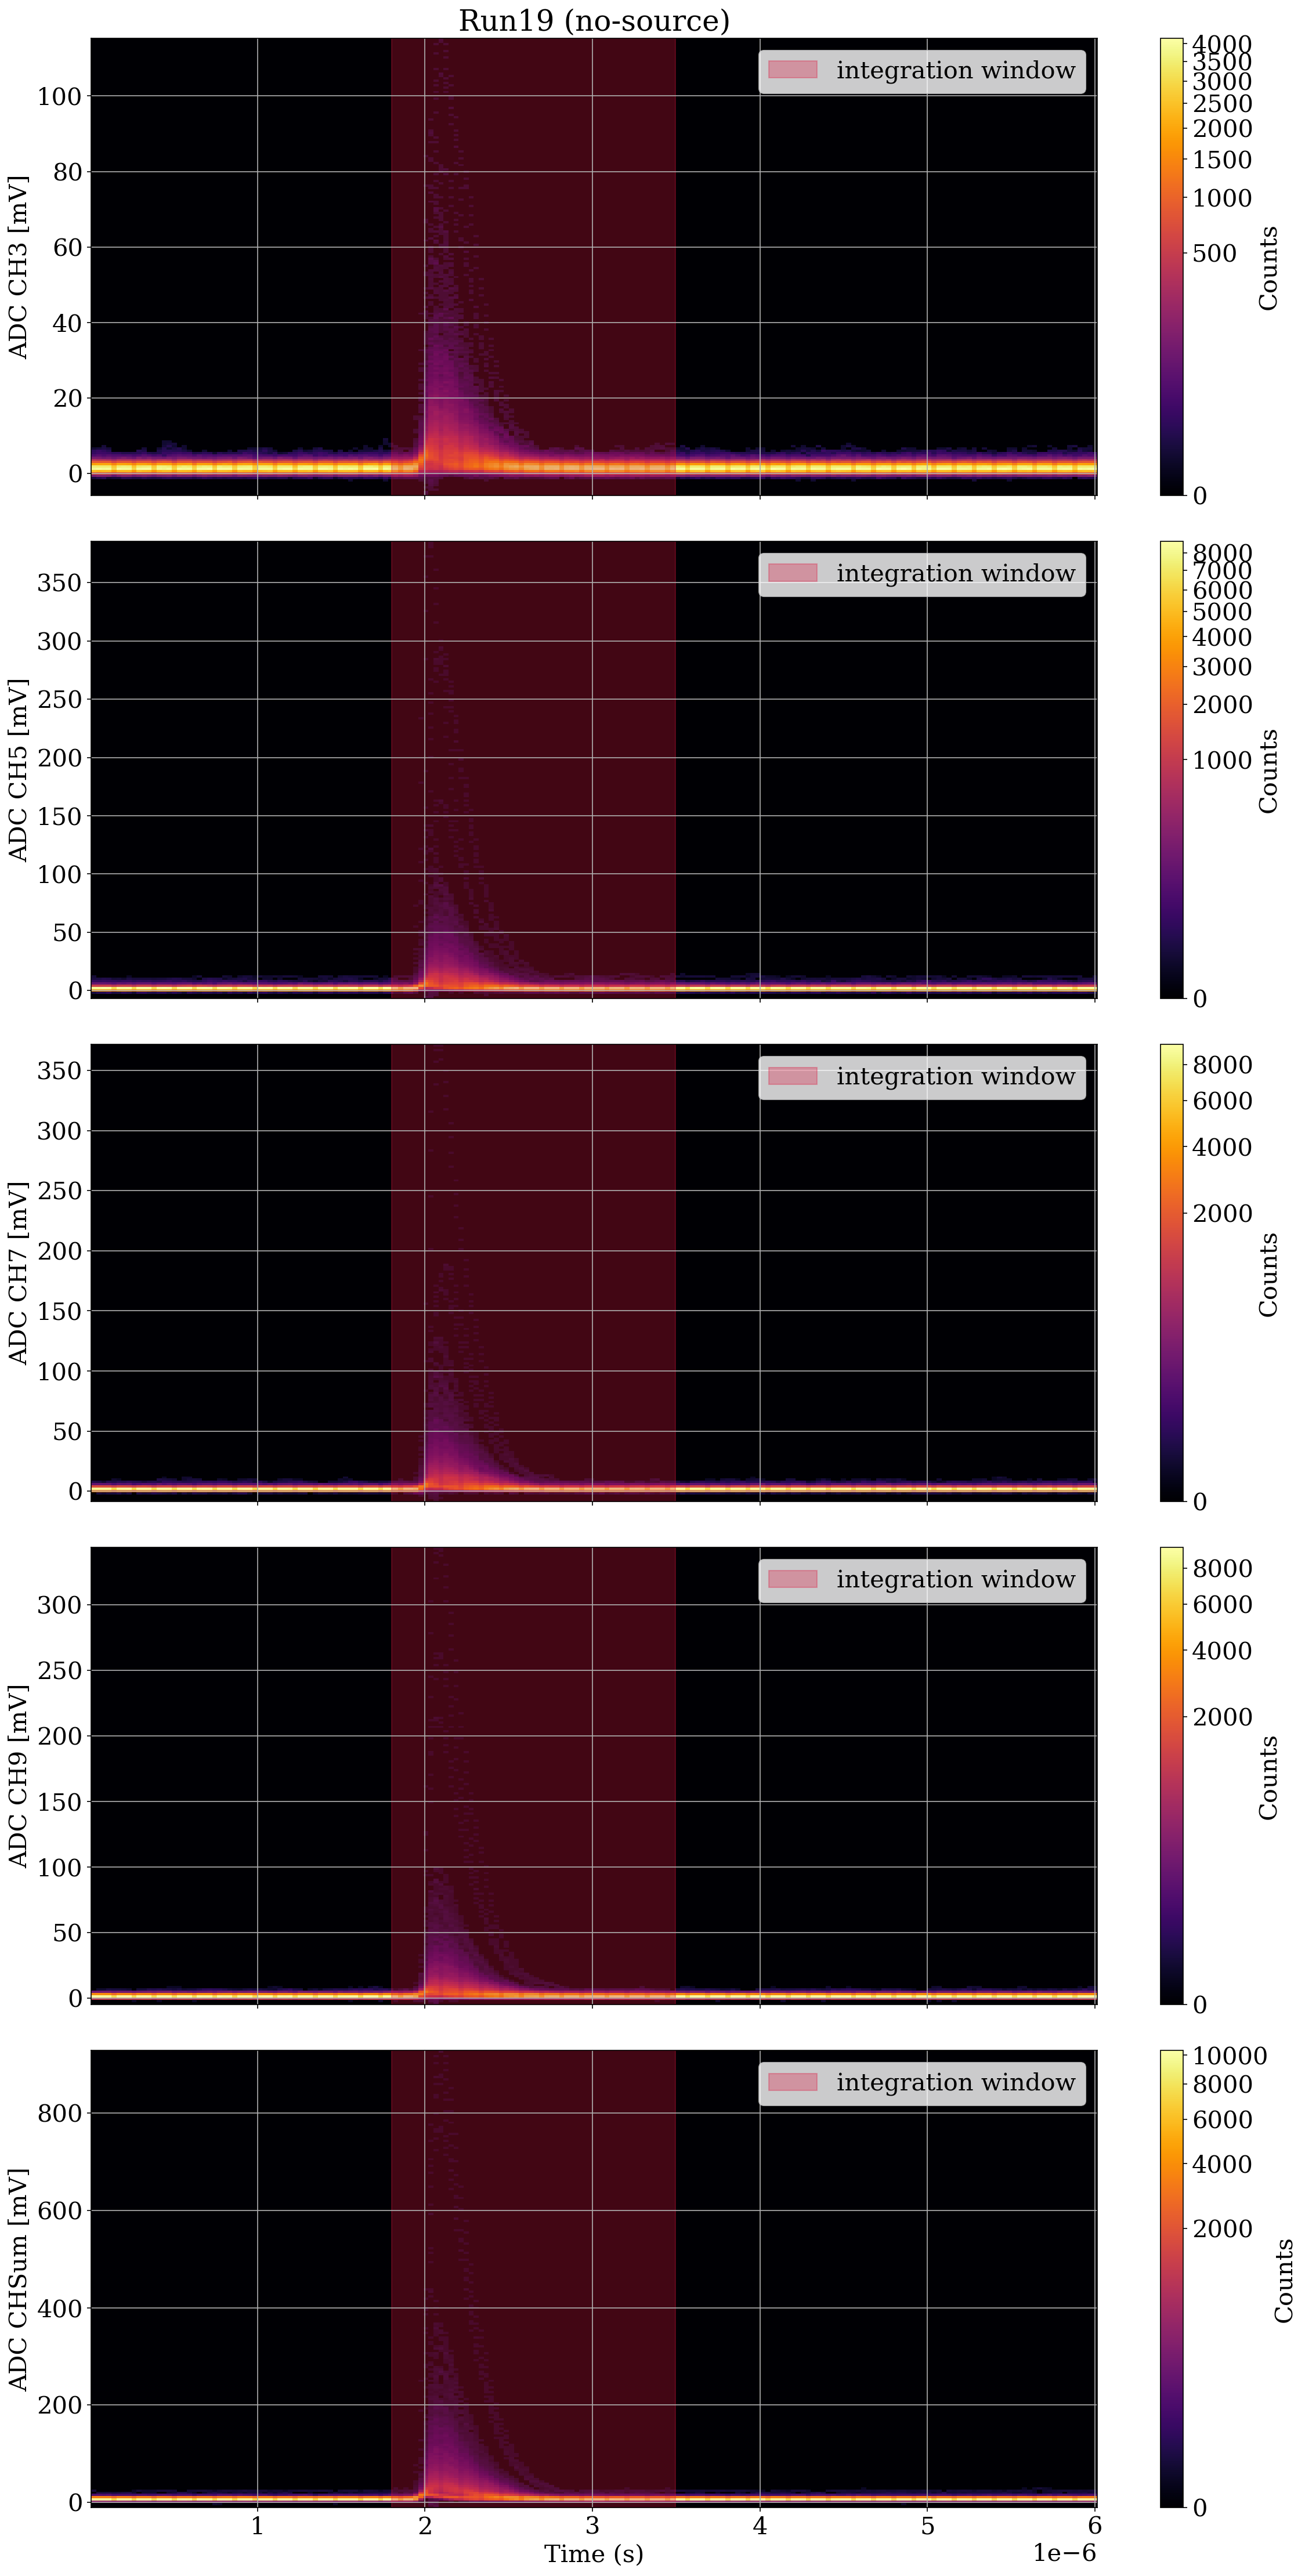

In [35]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f"{data_nosource['run']} ({data_nosource['source']})")
else:
    ax.set_title(f"{data_nosource['run']} ({data_nosource['source']})")


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage  = corrected_df_nosource[f'{channels[i]}'].values
    v_matrix = voltage.reshape(nevents_nosource, -1)
    # v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix
    
    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(t_matrix_nosource.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
                   cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    ax.fill_between(time_nosource[time_window_nosource], v_matrix_corrected.min(), v_matrix_corrected.max(), 
                    color = colors[1], alpha = 0.3, label = 'integration window')

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

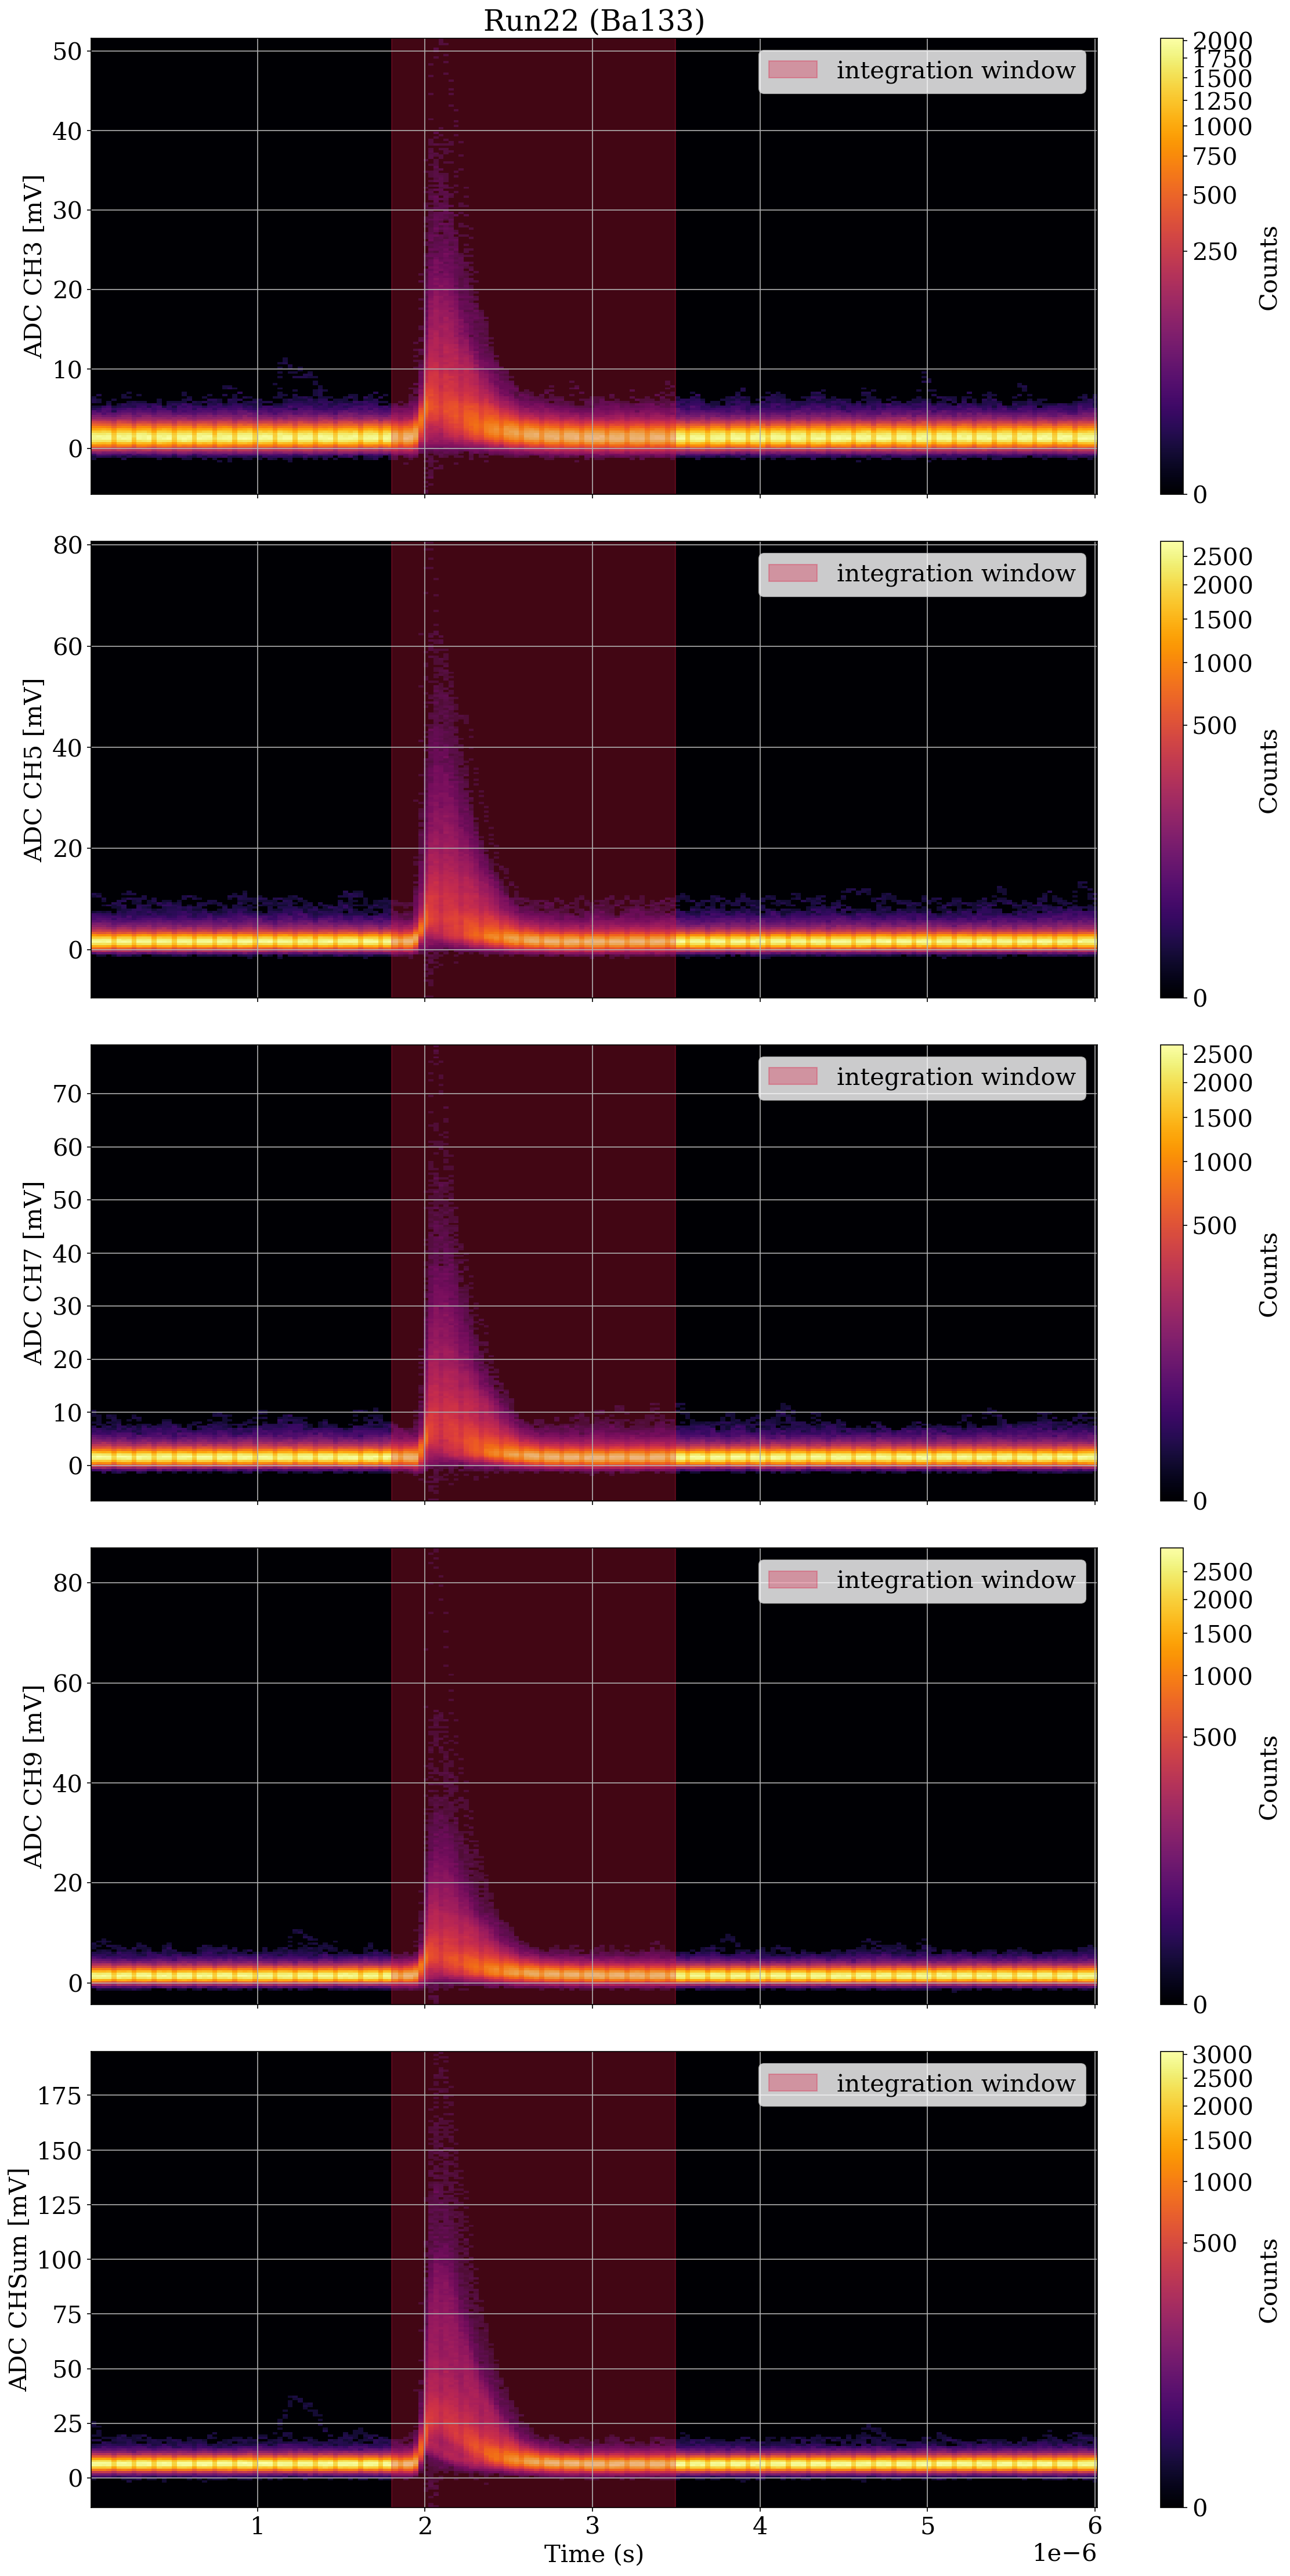

In [36]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f"{data_source['run']} ({data_source['source']})")
else:
    ax.set_title(f"{data_source['run']} ({data_source['source']})")


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage  = corrected_df_source[f'{channels[i]}'].values
    v_matrix = voltage.reshape(nevents_source, -1)
    # v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix
    
    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(t_matrix_source.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
                   cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    ax.fill_between(time_source[time_window_source], v_matrix_corrected.min(), v_matrix_corrected.max(), 
                    color = colors[1], alpha = 0.3, label = 'integration window')

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

Run19 is 38.65 mins long
Run22 is 8.91 mins long


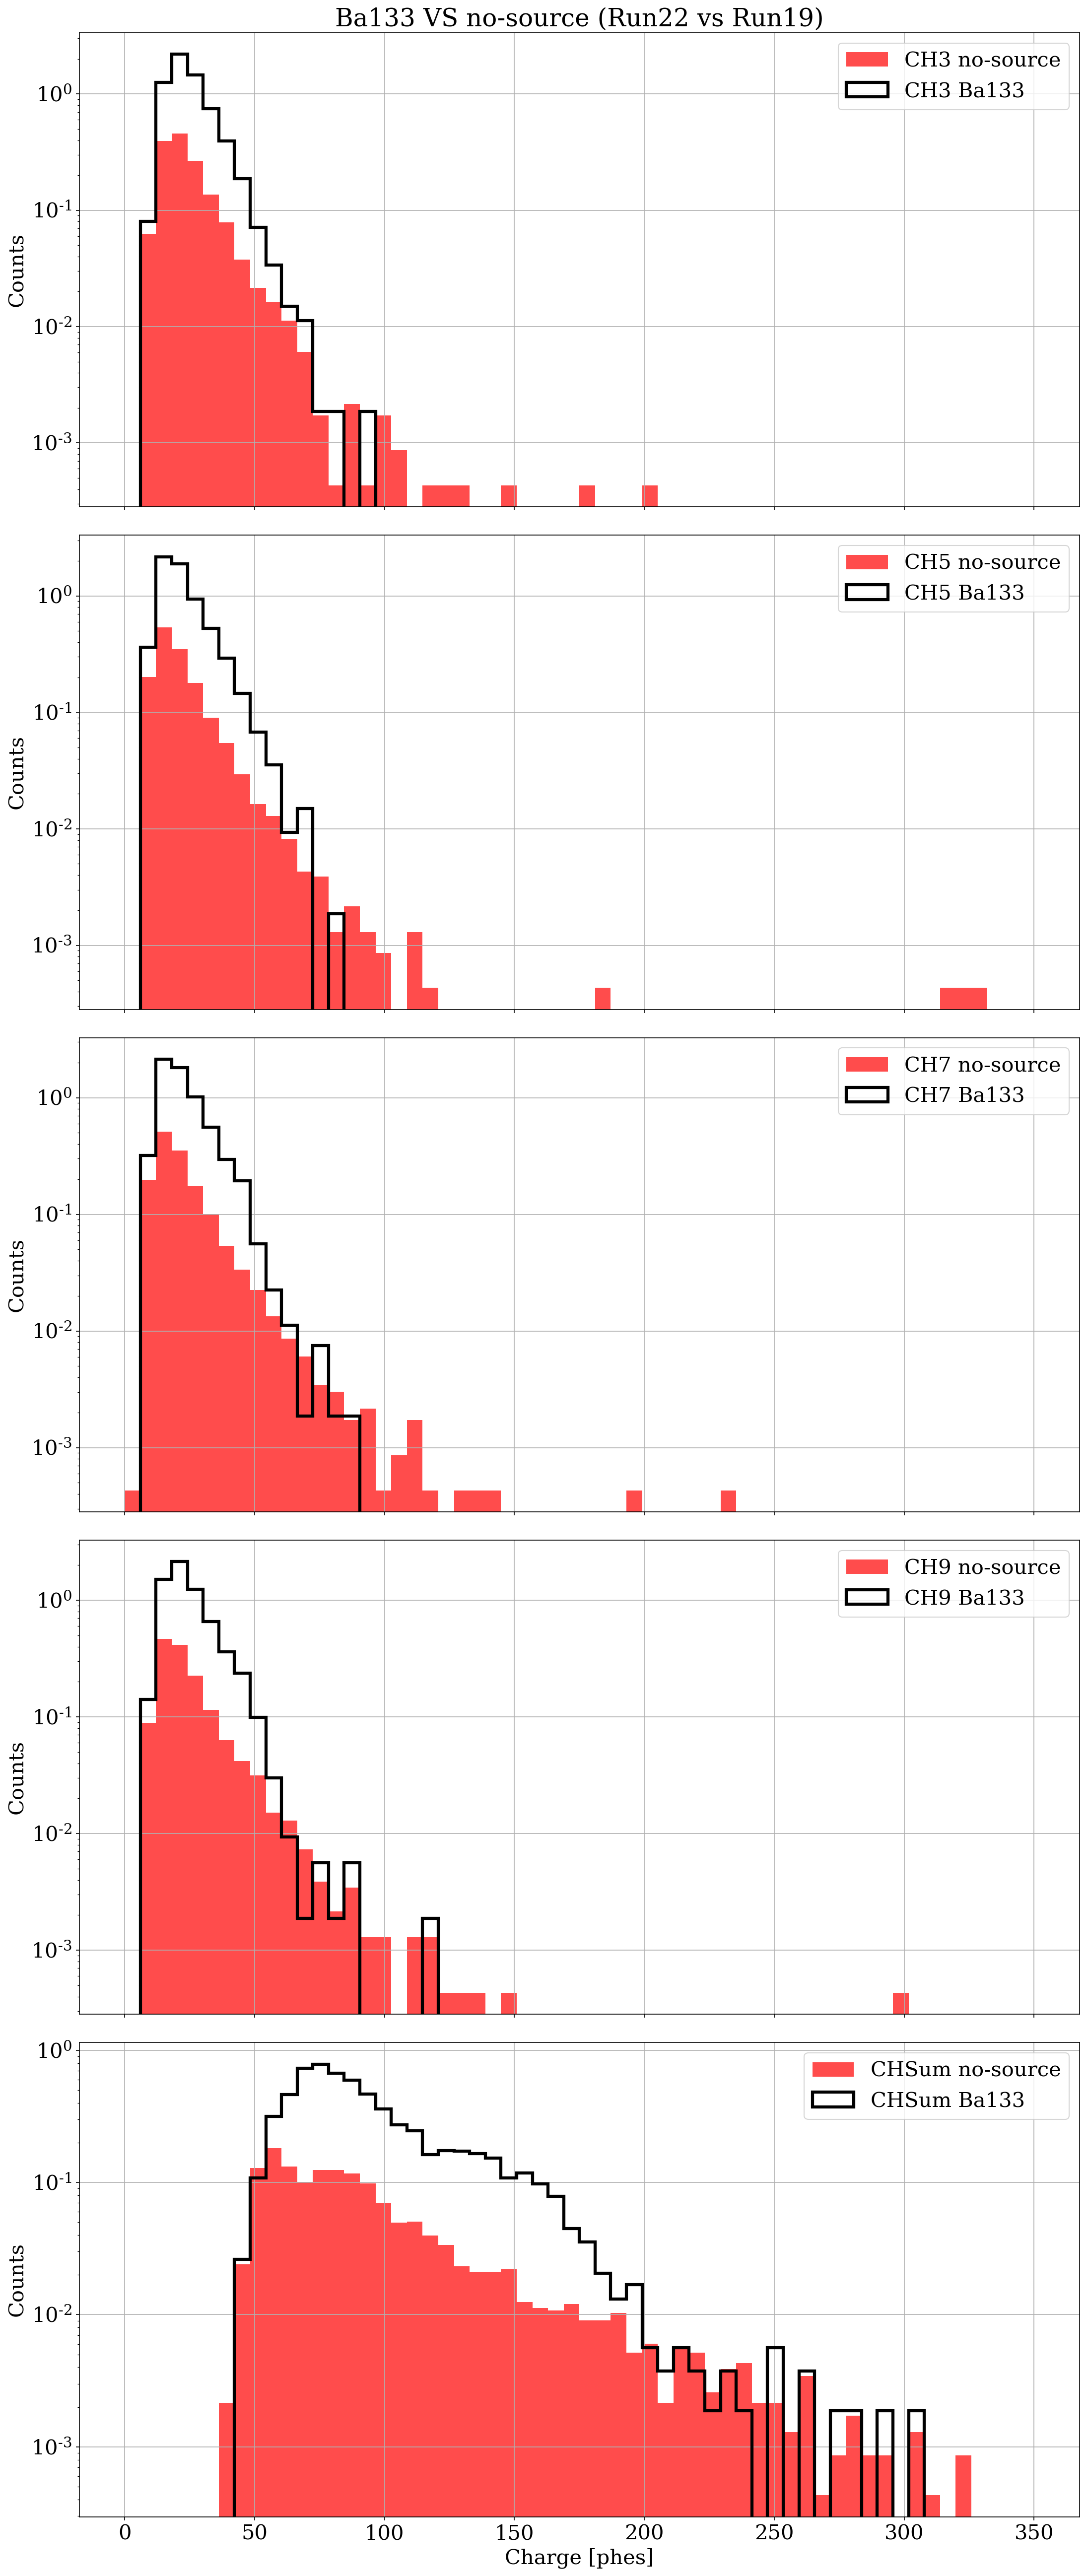

In [ ]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(15, len(channels)*7), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(15, 7), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f"{data_source['source']} VS {data_nosource['source']} ({data_source['run']} vs {data_nosource['run']})")
else:
    ax.set_title(f"{data_source['source']} VS {data_nosource['source']} ({data_source['run']} vs {data_nosource['run']})")

charge_nosource_Sum = 0
charge_source_Sum   = 0

run_duration_nosource   = ((corrected_df_nosource.groupby('file_idx').max().event_time - corrected_df_nosource.groupby('file_idx').min().event_time)*8e-9).sum()
print(f"{data_nosource['run']} is {run_duration_nosource/60:.2f} mins long")
run_duration_source     = ((corrected_df_source.groupby('file_idx').max().event_time - corrected_df_source.groupby('file_idx').min().event_time)*8e-9).sum()
print(f"{data_source['run']} is {run_duration_source/60:.2f} mins long")


# Plot CHs
for i, ch in enumerate(channels):

    if len(channels) > 1:
        ax = axs[i]
    
    # NO SOURCE -------------------------------------------------------------------------
    voltage_nosource = corrected_df_nosource[f'{channels[i]}'].values

    v_matrix_nosource                    = voltage_nosource.reshape(nevents_nosource, -1)
    # v_matrix_corrected_nosource, _, _    = cig.BaselineCorrection(v_matrix_nosource, window=window_width)
    v_matrix_corrected_nosource = v_matrix_nosource

    charge_nosource = np.trapz(v_matrix_corrected_nosource[:, time_window_nosource]*1e-3,
                      x = time_nosource[time_window_nosource]
                      ,axis = 1)
    
    if data_nosource['pes']:
        if ch != 'CHSum':
            charge_nosource = cig.ChargeToPes(charge_nosource, channel=i+1, 
                                        temp = data_nosource['temperature'], amplified = data_nosource['is_amplified'], CHAmp=data_nosource['amp_factors'])
            charge_nosource_Sum = charge_nosource_Sum + charge_nosource
        else:
            charge_nosource = charge_nosource_Sum


    events_nosource, bins, image = ax.hist(charge_nosource
                                ,bins = int(np.sqrt(len(charge_nosource))) 
                                ,weights=np.ones_like(charge_nosource)/run_duration_nosource
                                # ,range = (0, 350)
                                ,density = False
                                ,histtype   ='stepfilled'
                                ,color      = 'r'
                                ,ls         = '-'
                                ,lw         = 3
                                ,alpha      = 0.7
                                ,label = f"{ch} {data_nosource['source']}"
                                )
    
    # SOURCE -------------------------------------------------------------------------
    voltage_source = corrected_df_source[f'{channels[i]}'].values

    v_matrix_source                    = voltage_source.reshape(nevents_source, -1)
    # v_matrix_corrected_source, _, _    = cig.BaselineCorrection(v_matrix_source, window=window_width)
    v_matrix_corrected_source = v_matrix_source

    charge_source = np.trapz(v_matrix_corrected_source[:, time_window_source]*1e-3,
                      x = time_source[time_window_source]
                      ,axis = 1)

    if data_source['pes']:
        if ch != 'CHSum':
            charge_source = cig.ChargeToPes(charge_source, channel=i+1, 
                                        temp = data_source['temperature'], amplified = data_source['is_amplified'], CHAmp=data_source['amp_factors'])
            charge_source_Sum = charge_source_Sum + charge_source
        else:
            charge_source = charge_source_Sum

    events_source, bins, image = ax.hist(charge_source
                                ,bins = bins
                                ,weights=np.ones_like(charge_source)/run_duration_source
                                ,density = False
                                ,histtype   ='step'
                                ,color      = 'k'
                                ,ls         = '-'
                                ,lw         = 3
                                ,alpha      = 1
                                ,label = f"{ch} {data_source['source']}"
                                )
    
    ax.set_ylabel(f'Counts')
    ax.grid(True)
    ax.set_yscale('log')
    ax.legend()

if len(channels) > 1:
    if pes:
        axs[-1].set_xlabel(r'Charge [phes]')
    else:
        axs[-1].set_xlabel(r'Charge [V $\cdot$ s]')
else:
    ax.set_xlabel(r'Charge [V $\cdot$ s]')

# plt.xlim(0.5, 550)

# Improve layout
plt.tight_layout()
plt.show()

In [62]:
charge_nosource.min()

40.41990540493569

In [63]:
bins

array([  0.        ,   6.03448276,  12.06896552,  18.10344828,
        24.13793103,  30.17241379,  36.20689655,  42.24137931,
        48.27586207,  54.31034483,  60.34482759,  66.37931034,
        72.4137931 ,  78.44827586,  84.48275862,  90.51724138,
        96.55172414, 102.5862069 , 108.62068966, 114.65517241,
       120.68965517, 126.72413793, 132.75862069, 138.79310345,
       144.82758621, 150.86206897, 156.89655172, 162.93103448,
       168.96551724, 175.        , 181.03448276, 187.06896552,
       193.10344828, 199.13793103, 205.17241379, 211.20689655,
       217.24137931, 223.27586207, 229.31034483, 235.34482759,
       241.37931034, 247.4137931 , 253.44827586, 259.48275862,
       265.51724138, 271.55172414, 277.5862069 , 283.62068966,
       289.65517241, 295.68965517, 301.72413793, 307.75862069,
       313.79310345, 319.82758621, 325.86206897, 331.89655172,
       337.93103448, 343.96551724, 350.        ])

In [64]:
events_source.sum(), events_nosource.sum()

(6.442664664235821, 1.4895014934450084)

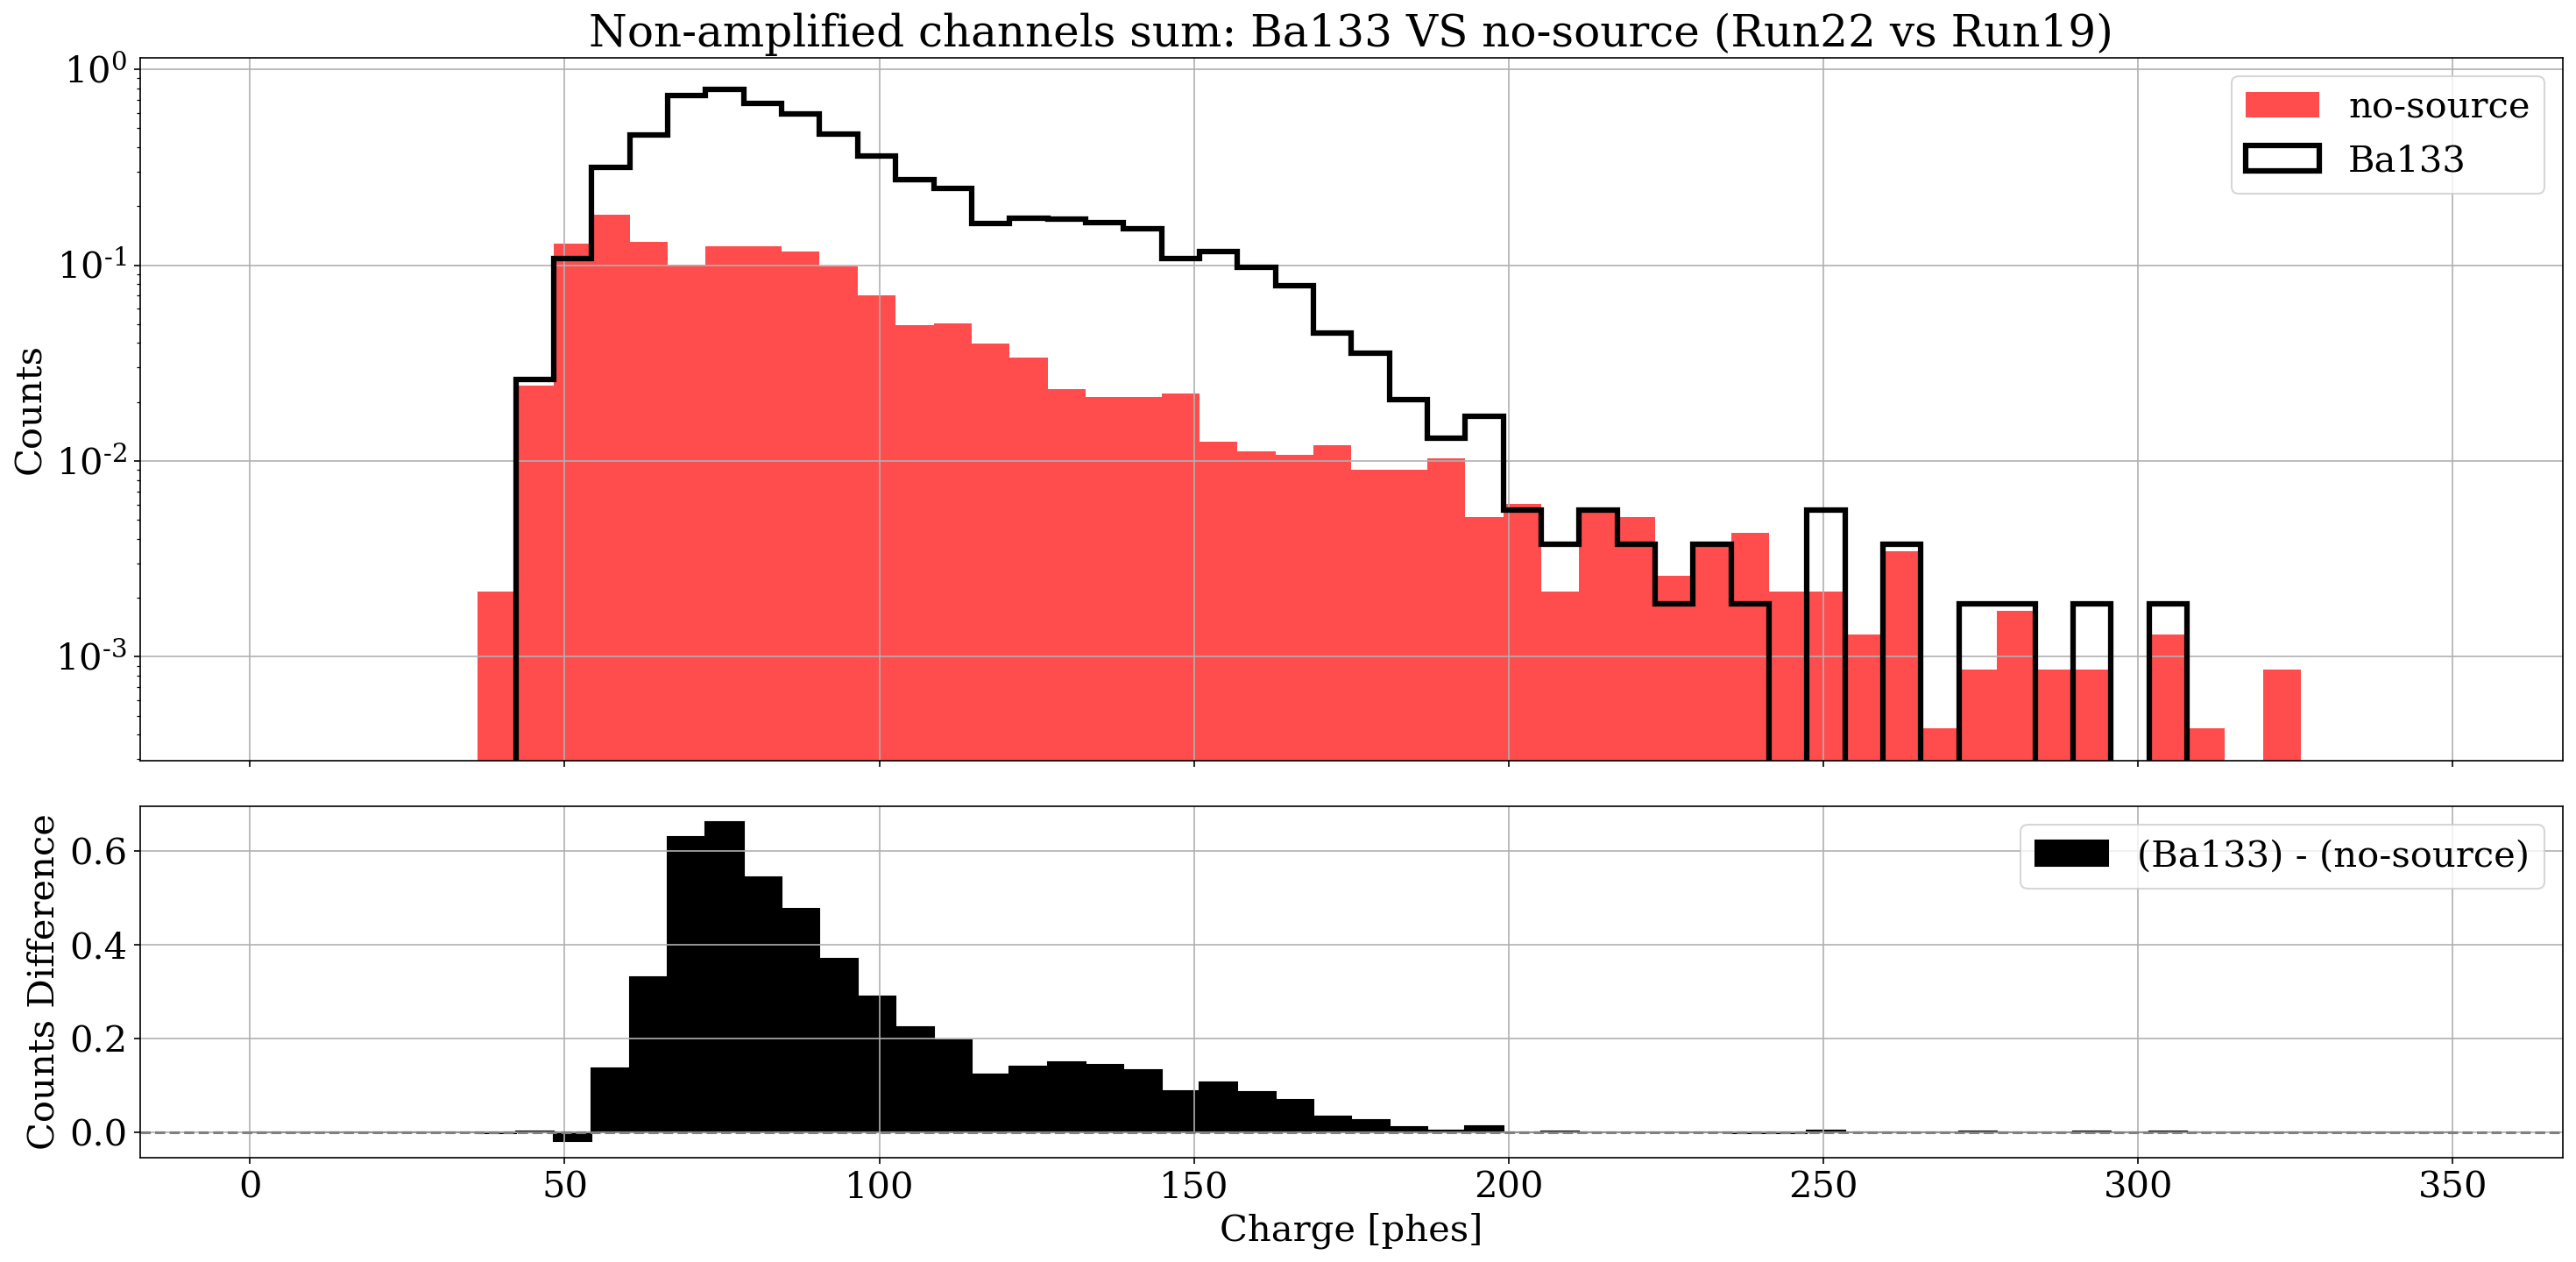

: 

In [ ]:
# Create GridSpec with two rows, one smaller
fig, axs = plt.subplots(2, 1,
                        figsize=(20, 10),
                        dpi=150,
                        sharex=True,
                        gridspec_kw={'height_ratios': [2, 1]}  # top subplot twice as tall
                        )

if amplified:
    axs[0].set_title(f"Amplified channels sum: {data_source['source']} VS {data_nosource['source']} ({data_source['run']} vs {data_nosource['run']})")
else:
    axs[0].set_title(f"Non-amplified channels sum: {data_source['source']} VS {data_nosource['source']} ({data_source['run']} vs {data_nosource['run']})")



# PLOT 1: Sum histograms
ax = axs[0]

events_nosource, bins, image = ax.hist(charge_nosource_Sum
                                        ,bins = bins
                                        ,weights=np.ones_like(charge_nosource_Sum)/run_duration_nosource
                                        ,density = False
                                        ,histtype   ='stepfilled'
                                        ,color      = 'r'
                                        ,ls         = '-'
                                        ,lw         = 3
                                        ,alpha      = 0.7
                                        ,label = f"{data_nosource['source']}"
                                        )


events_source, bins, image = ax.hist(charge_source_Sum
                                    ,bins = bins
                                    ,weights=np.ones_like(charge_source_Sum)/run_duration_source
                                    ,density = False
                                    ,histtype   ='step'
                                    ,color      = 'k'
                                    ,ls         = '-'
                                    ,lw         = 3
                                    ,alpha      = 1
                                    ,label = f"{data_source['source']}"
                                    )


ax.set_ylabel(f'Counts')
ax.grid(True)
ax.set_yscale('log')
ax.legend()



# PLOT 2: Sum histograms
ax = axs[1]

bin_centers = (bins[1:] + bins[:-1])/2

events_difference = events_source - events_nosource

width = np.diff(bins)
ax.bar(bin_centers, events_difference, width=width, align='center',
       color='k', edgecolor='k', alpha=1, label=f"({data_source['source']}) - ({data_nosource['source']})")

ax.axhline(0, color='grey', linestyle='--')
ax.set_ylabel('Counts Difference')
ax.set_yscale('linear')     # linear to show negatives
ax.grid(True)
ax.legend()

if pes:
    axs[-1].set_xlabel(r'Charge [phes]')
else:
    axs[-1].set_xlabel(r'Charge [V $\cdot$ s]')


# Improve layout
plt.tight_layout()
plt.show()